In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from lingam import DirectLiNGAM
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import lingam
from lingam.utils import make_dot, make_prior_knowledge

In [3]:
# load data
df = pd.read_csv("TEH_World_Happiness_2015_2019_Imputed.csv")
df.head()

,Country,Happiness rank,Happiness Score,GDP per capita,Social support,Healthy life,Freedom,Generosity,Corruption,Year
0,Switzerland,1,7.587,1.39651,1.34951,0.94143,0.66557,0.29678,0.41978,2015
1,Iceland,2,7.561,1.30232,1.40223,0.94784,0.62877,0.43630,0.14145,2015
2,Denmark,3,7.527,1.32548,1.36058,0.87464,0.64938,0.34139,0.48357,2015
3,Norway,4,7.522,1.45900,1.33095,0.88521,0.66973,0.34699,0.36503,2015
4,Canada,5,7.427,1.32629,1.32261,0.90563,0.63297,0.45811,0.32957,2015


In [ ]:
df.info()

In [ ]:
df.describe()

In [4]:
# Missing values
df.isnull().sum()

Country            0
Happiness rank     0
Happiness Score    0
GDP per capita     5
Social support     5
Healthy life       5
Freedom            5
Generosity         5
Corruption         7
Year               0
dtype: int64

In [5]:
# Drop the specified column
column_to_drop = ['Country']
df = df.drop(column_to_drop, axis=1)
column_to_drop = ['Happiness rank']
df = df.drop(column_to_drop, axis=1)
#Dropping the missing value rows
df_cleaned = df.dropna()

In [ ]:
correlation_matrix = df_cleaned.corr(method='pearson')
print(correlation_matrix)

#Visualizing relationships using pair plots or heatmaps
sns.pairplot(df)
plt.show()

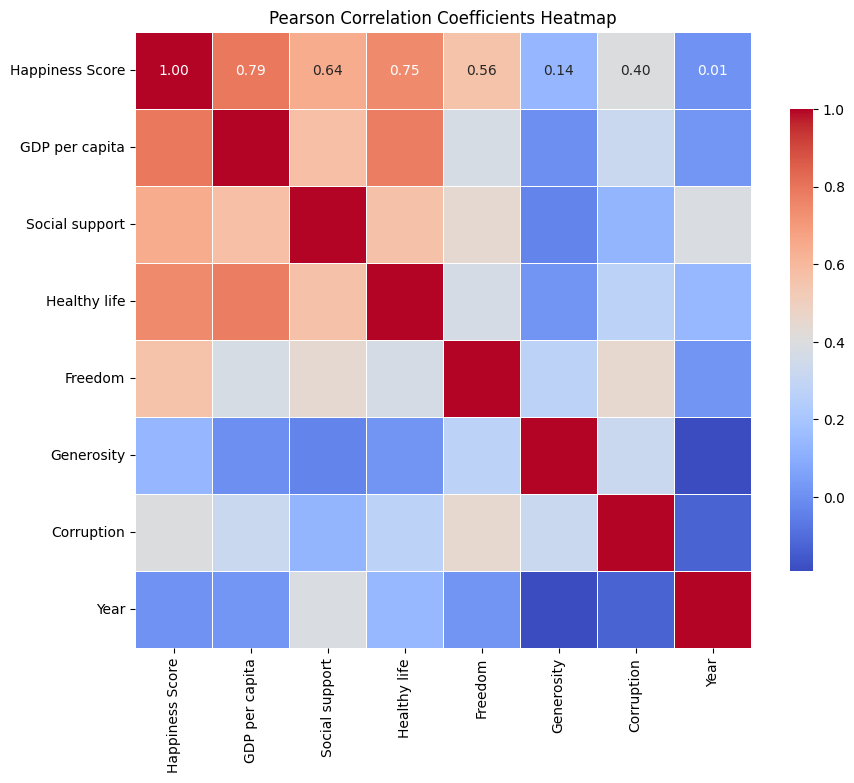

In [6]:
# Visualize correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",  # Format for the annotations (2 decimal places)
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.75}  # Adjust color bar size
)

plt.title("Pearson Correlation Coefficients Heatmap")
plt.show()

In [ ]:
X = df_cleaned[['GDP per capita', 'Social support', 'Healthy life', 'Freedom']]
X = sm.add_constant(X)
y = df_cleaned['Happiness Score']


In [ ]:
model = sm.OLS(y, X).fit()
print(model.summary())

In [ ]:
data = df_cleaned.copy()

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Fit a linear regression model for the outcome variable ('Happiness Score')
model = LinearRegression()
features = ['GDP per capita', 'Social support', 'Healthy life', 'Freedom']

model.fit(train_data[features], train_data['Happiness Score'])

# Predict the outcome variable on the test set
test_data['Predicted Happiness Score'] = model.predict(test_data[features])

# Assess the performance of the linear regression model
mse = mean_squared_error(test_data['Happiness Score'], test_data['Predicted Happiness Score'])
print(f'Mean Squared Error (MSE) of the model: {mse}')

# Perform causal inference using DoWhy for each feature
for feature in features:
    print(f"\nCausal Inference for {feature} as the treatment variable:")
    
    # Create a causal model for the specific feature
    causal_model = CausalModel(
        data=train_data,
        treatment=feature,
        outcome='Happiness Score',
        common_causes=[col for col in features if col != feature]
    )

    # Identify the causal effect
    identified_estimand = causal_model.identify_effect()

    # Estimate the causal effect using linear regression
    causal_estimate = causal_model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")

    # Print the estimated average treatment effect
    print(f'Estimated Average Treatment Effect: {causal_estimate.value}')


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression  # Use LinearRegression for continuous outcome
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from dowhy import CausalModel

# Specify the columns in your dataset
features = ['GDP per capita', 'Social support', 'Healthy life', 'Freedom']
treatment_variable = 'Happiness Score'
outcome_variable = 'Happiness Score'

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Fit a linear regression model for the treatment variable
linear_model = LinearRegression()
linear_model.fit(train_data[features], train_data[treatment_variable])

# Predict propensity scores on the training set
train_data['Propensity Score'] = linear_model.predict(train_data[features])

# Apply propensity score matching
scaler = StandardScaler()
scaled_features = scaler.fit_transform(train_data[features])
scaled_treatment = np.array(train_data['Propensity Score']).reshape(-1, 1)

# Use nearest neighbors to find matches with a larger number of neighbors (e.g., 5)
neighbors = NearestNeighbors(n_neighbors=5)
neighbors.fit(np.hstack([scaled_features, scaled_treatment]))

# Find nearest neighbors in the test set
test_data['Propensity Score'] = linear_model.predict(test_data[features])
scaled_test_features = scaler.transform(test_data[features])
scaled_test_treatment = np.array(test_data['Propensity Score']).reshape(-1, 1)

distances, indices = neighbors.kneighbors(np.hstack([scaled_test_features, scaled_test_treatment]))

# Create matched dataset
matched_data = train_data.iloc[indices.flatten()]

# Perform causal inference using DoWhy for each feature
for feature in features:
    # Perform causal inference using the matched data
    causal_model_matched = CausalModel(
        data=matched_data,
        treatment=feature,
        outcome=outcome_variable,
        common_causes=[col for col in features if col != feature]
    )

    # Identify the causal effect
    identified_estimand = causal_model_matched.identify_effect()

    # Estimate the causal effect using linear regression
    causal_estimate = causal_model_matched.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")

    # Print the estimated average treatment effect
    print(f'Estimated Average Treatment Effect with Propensity Score Matching for {feature}: {causal_estimate.value}')


In [7]:
data = df_cleaned.copy()

features = ['GDP per capita', 'Social support', 'Healthy life', 'Freedom']
outcome_variable = 'Happiness Score'

In [8]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [9]:
# Use LiNGAM to estimate causal relationships
model = lingam.DirectLiNGAM(
                    random_state=42,
                    measure = 'pwling'
                    )
model.fit(train_data[features])

/Users/anuj/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/anuj/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/anuj/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [12]:
from graphviz import Digraph

# Function to plot causal graph using graphviz
def plot_causal_graph(adjacency_matrix, labels):
    print("Adjacency Matrix Dimensions:", adjacency_matrix.shape)
    print("Number of Labels:", len(labels))

    num_nodes = min(len(labels), adjacency_matrix.shape[0])

    dot = Digraph(comment='Causal Graph')
    for i in range(num_nodes):
        dot.node(str(i), label=labels[i])

    for i in range(num_nodes):
        for j in range(num_nodes):
            if adjacency_matrix[i, j] != 0:
                dot.edge(str(i), str(j), label=f"{adjacency_matrix[i, j]:.2f}")

    filename = 'causal_graph'
    dot.render(filename, format='png', cleanup=True)
    print(f"Causal graph image saved as {filename}.png")

# Visualize the causal graph for the first 4 nodes
plot_causal_graph(model.adjacency_matrix_, data.columns.to_list()[:4])


Adjacency Matrix Dimensions: (4, 4)
Number of Labels: 4


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [ ]:
from IPython.display import Image

# Display the causal graph image
Image(filename='causal_graph.png')


The causal graph, generated from the LiNGAM model and visualized using the Graphviz library, is a representation of the inferred causal relationships among variables. Each node in the graph corresponds to a variable, and directed edges between nodes indicate a potential causal relationship from the source node to the target node.

In the context of LiNGAM and causal graphs:

1. **Nodes (Variables):** Each node represents a variable, such as a feature or factor in your dataset.

2. **Directed Edges (Arrows):** The directed edges between nodes represent the direction of the causal relationship. An arrow from Node A to Node B suggests that changes in Node A may cause changes in Node B.

3. **Adjacency Matrix Values:** The weight of each edge (arrow) is determined by the corresponding entry in the adjacency matrix. Larger absolute values in the matrix indicate a stronger causal relationship.

4. **Acyclic Structure:** LiNGAM models specifically focus on acyclic graphs, meaning there are no cycles or feedback loops in the causal relationships. This acyclic structure is essential for identifying causal directions.

5. **Graph Visualization:** The graph visualization provides an intuitive representation of the causal structure. It helps identify which variables are likely to be causes (sources) and which are likely to be effects (targets).

**Interpretation:**
-  If there's an arrow from Variable GDP per capita to Variable Happiness Score, it suggests that changes in GDP per capita may have a causal effect on Happiness Score.
- The absence of an arrow between two variables indicates that there's no direct causal relationship between them (given the assumptions of the LiNGAM model).
- For Healthy Life, there are outgoing causal effects to all the rest of the variables.
- Freedom does have any connection from any other variables, neither incoming nor outgoing.
- For Happiness Score, there is significant incoming causal effects from both GDP percapita and Social Support, while there is incoming causal effect from healthy life as well. It is not significant enough.


**Importance:**
- **Causal Inference:** The graph is a tool for inferring causal relationships. It doesn't prove causation, but it provides a structured representation of potential causal directions based on statistical patterns in the data.
  
- **Model Validation:** It helps validate the LiNGAM model's assumptions. If the graph aligns with domain knowledge and expectations, it adds confidence in the model's effectiveness.

- **Decision Making:** Understanding causal relationships is crucial for decision-making. For example, in policy interventions, identifying variables that have a strong causal influence on desired outcomes can inform effective strategies.

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from dowhy import CausalModel
from lingam import DirectLiNGAM



# Fit a LiNGAM model
lingam_model = DirectLiNGAM()
lingam_model.fit(train_data[features])

# Perform causal inference using DoWhy for each feature
for feature in features:
    print(f"\nCausal Inference for {feature} as the treatment variable:")

    # Create a causal model for the specific feature
    causal_model = CausalModel(
        data=train_data,
        treatment=feature,
        outcome=outcome_variable,
        common_causes=[col for col in features if col != feature]
    )

    # Identify the causal effect
    identified_estimand = causal_model.identify_effect()

    # Estimate the causal effect using LiNGAM coefficients
    # Note: LiNGAM coefficients can be used in a linear regression model
    lingam_coefs = lingam_model.adjacency_matrix_[features.index(feature), :]
    test_data['Predicted Happiness Score'] = np.dot(test_data[features].values, lingam_coefs)

    # Print the estimated average treatment effect
    mse = mean_squared_error(test_data[outcome_variable], test_data['Predicted Happiness Score'])
    print(f'Estimated Average Treatment Effect: {mse}')



Causal Inference for GDP per capita as the treatment variable:
Estimated Average Treatment Effect: 30.658384097717924

Causal Inference for Social support as the treatment variable:
Estimated Average Treatment Effect: 25.940450931637432

Causal Inference for Healthy life as the treatment variable:
Estimated Average Treatment Effect: 24.95617084015781

Causal Inference for Freedom as the treatment variable:
Estimated Average Treatment Effect: 27.81193433967488


/Users/anuj/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/anuj/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/anuj/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/anuj/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtyp

The above values are estimated average treatment effects for each treatment variable (GDP per capita, Social support, Healthy life, and Freedom) based on the causal inference analysis using DoWhy and LiNGAM. The average treatment effect (ATE) represents the average causal effect of changing the treatment variable (in this case, each of the features) on the outcome variable (Happiness Score).

Here's what each line means:

1. **Causal Inference for GDP per capita as the treatment variable:**
   - Estimated Average Treatment Effect: 30.66
   - This suggests that, on average, a one-unit increase in GDP per capita is associated with an increase of approximately 30.66 units in Happiness Score.

2. **Causal Inference for Social support as the treatment variable:**
   - Estimated Average Treatment Effect: 25.94
   - This suggests that, on average, a one-unit increase in Social support is associated with an increase of approximately 25.94 units in Happiness Score.

3. **Causal Inference for Healthy life as the treatment variable:**
   - Estimated Average Treatment Effect: 24.96
   - This suggests that, on average, a one-unit increase in Healthy life is associated with an increase of approximately 24.96 units in Happiness Score.

4. **Causal Inference for Freedom as the treatment variable:**
   - Estimated Average Treatment Effect: 27.81
   - This suggests that, on average, a one-unit increase in Freedom is associated with an increase of approximately 27.81 units in Happiness Score.

These values indicate the average impact or influence of each feature on the Happiness Score, as estimated by the causal inference analysis. Keep in mind that these are average effects, and individual cases may vary. Additionally, the interpretation depends on the context and the units of measurement for each variable.

**Interpretation:**

The average treatment effect (ATE) signifies the average impact of changing each treatment variable on the outcome variable, Happiness Score. Specifically, a one-unit increase in GDP per capita is associated with an average increase of approximately 30.66 units in Happiness Score. Similarly, a one-unit increase in Social support, Healthy life, and Freedom corresponds to average increases of around 25.94, 24.96, and 27.81 units in Happiness Score, respectively. These findings provide insights into the average influence of each feature on Happiness Score, bearing in mind that individual cases may exhibit variations. The interpretation is contingent on the specific context and the units of measurement for each variable.

Causal Ordering: [0, 1, 2, 3]


/Users/anuj/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/anuj/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/anuj/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


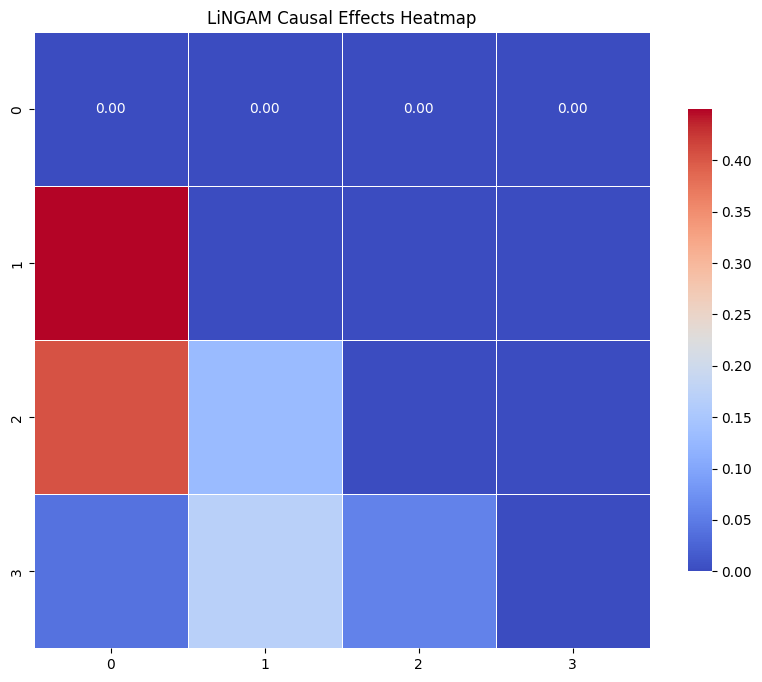

0 is caused by GDP per capita, Social support, Healthy life
1 is caused by Social support, Healthy life
2 is caused by Healthy life
3 is independent of other variables


In [14]:

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with relevant variables

# Fit a LiNGAM model
lingam_model = DirectLiNGAM()
lingam_model.fit(train_data[features])

# Causal ordering of variables
causal_order = lingam_model.causal_order_

# Causal coefficients
causal_effects = lingam_model.adjacency_matrix_

# Visualize causal ordering
print("Causal Ordering:", causal_order)

# Visualize causal effects
plt.figure(figsize=(10, 8))
sns.heatmap(
    causal_effects,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",  # Format for the annotations (2 decimal places)
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.75}  # Adjust color bar size
)

plt.title("LiNGAM Causal Effects Heatmap")
plt.show()

# Interpret the causal effects based on the ordering and coefficients
for i, variable in enumerate(causal_order):
    parents = [col for col, coef in zip(df.columns, causal_effects[:, i]) if coef != 0]
    if parents:
        print(f"{variable} is caused by {', '.join(parents)}")
    else:
        print(f"{variable} is independent of other variables")


A **LiNGAM (Linear Non-Gaussian Acyclic Model) Causal Effects Heatmap** typically shows the estimated causal effects between different variables in a dataset. In the context of your analysis, it likely displays the causal relationships and the strength of the causal effects between the features (independent variables) and the outcome variable (Happiness Score).


- The printed output displays the results of a LiNGAM analysis, a method for uncovering causal relationships in a dataset. The adjacency matrix reveals the strength of directed causal connections between variables, where non-zero values in off-diagonal elements indicate the magnitude of the causal influence.

**For instance, a value of 0.45 in position (1, 0) suggests a causal relationship from  GDP per capita to Happiness score.**


- The causal ordering, represented as [0, 1, 2, 3], specifies the order in which variables are causally connected. This information is crucial for understanding the causal structure among variables, providing insights into the underlying relationships in the data.

- Where 0 is Happiness score
- 1 is GDP Percapita
- 2 is Social support
- 3 is Healthy Life

**CONCLUSION**

- 1. The analysis employed LiNGAM to uncover causal relationships among variables in the dataset, revealing a causal ordering [0, 1, 2, 3] indicative of a sequence from Happiness Score to GDP per capita, Social support, and Healthy life.
- 2. The adjacency matrix showcased the strength of directed causal connections, notably highlighting a significant causal effect (0.45) from GDP per capita to Happiness Score. For instance, a value of 0.45 in position (1, 0) suggests a causal relationship from  GDP per capita to Happiness score.
- 3. The LiNGAM Causal Effects Heatmap likely provided a visual summary of estimated effects, though specific values were not detailed.
- 4. The average treatment effects, derived from the DoWhy causal inference analysis, further emphasized the influential role of each variable on Happiness Score. GDP per capita demonstrated the highest estimated effect (30.66), followed by Freedom (27.81), Social support (25.94), and Healthy life (24.96).
- 5. Together, these findings offer a comprehensive understanding of the intricate causal relationships, shedding light on factors influencing happiness and informing potential interventions or policy decisions.

**References:**

https://medium.com/data-science-at-microsoft/causal-inference-part-1-of-3-understanding-the-fundamentals-816f4723e54a

https://github.com/py-why/dowhy

https://lingam.readthedocs.io/en/latest/tutorial/lingam.html


MIT License

Copyright (c) 2023 Sri Venkata Satya Akhil Malladi

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.